# Library

In [1]:
# Import standard data processing libraries
import pandas as pd
import numpy as np
import random
import os

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Set log level
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tempfile
import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle
import re

# Filter warnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Import visualization library
import matplotlib.pyplot as plt

# Import Machine Learning and Data Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (precision_recall_curve, average_precision_score, 
                             confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, balanced_accuracy_score)
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight

# Import Deep Learning libraries - Keras & TensorFlow
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Dense, Input, GlobalMaxPooling1D, LSTM, GRU, 
                                     Bidirectional, Dropout, BatchNormalization, SimpleRNN)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Activation


# Functions

In [2]:
# Fungsi Setiap Arsiterktur
# Model GRU
def make_model_GRU(look_back, n_features, units, learning_rate, num_layers, dropout_rate=0.2):
    model = Sequential()
    # Menambahkan layer GRU
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # True untuk layer bukan terakhir
        model.add(GRU(
            units=units,
            activation='relu',
            input_shape=(look_back, n_features),
            return_sequences=return_sequences,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=l1_l2(l1=1e-5, l2=1e-4)
        ))
        model.add(Dropout(dropout_rate))

    # Menambahkan layer Dense
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1, activation='sigmoid'))

    # Mengonfigurasi optimizer
    adam_optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=METRICS)
    return model

# Model LSTM
def make_model_LSTM(look_back, n_features, units, learning_rate, num_layers, dropout_rate=0.2):
    model = Sequential()
    # Menambahkan layer
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # True untuk layer bukan terakhir
        model.add(LSTM(
            units=units,
            activation='relu',
            input_shape=(look_back, n_features),
            return_sequences=return_sequences,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=l1_l2(l1=1e-5, l2=1e-4)
        ))
        model.add(Dropout(dropout_rate))

    # Menambahkan layer Dense
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1, activation='sigmoid'))

    # Mengonfigurasi optimizer
    adam_optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=METRICS)
    return model

# Model RNN
def make_model_RNN(look_back, n_features, units, learning_rate, num_layers, dropout_rate=0.2):
    model = Sequential()
    # Menambahkan layer
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # True untuk layer bukan terakhir
        model.add(SimpleRNN(
            units=units,
            activation='relu',
            input_shape=(look_back, n_features),
            return_sequences=return_sequences,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=l1_l2(l1=1e-5, l2=1e-4)
        ))
        model.add(Dropout(dropout_rate))

    # Menambahkan layer Dense
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1, activation='sigmoid'))

    # Mengonfigurasi optimizer
    adam_optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=METRICS)
    return model

# Fungsi split data
def split_data(data, start, end):
    return data[(data.index >= start) & (data.index <= end)]

# Fungsi untuk mengubah fitur X menjadi format dengan lag untuk RNN, GRU, LSTM
def create_lagged_features_lstm(X, look_back):
    """
    Creates lagged features for LSTM, GRU, RNN
    
    Args:
    X (array-like): The input features.
    look_back (int): The number of lag days.

    Returns:
    numpy.array: Transformed features with lag.
    """
    X_lagged = []
    for i in range(look_back, len(X)):
        X_lagged.append(X[i-look_back:i, :])
    return np.array(X_lagged)

# Metrik PRC AUC
METRICS = [
    'accuracy',
    AUC(name='prc', curve='PR'),
]

# Time Steps
look_back = 5

# Fungsi untuk mengubah fitur X menjadi format dengan lag untuk random forest dan xgboost
def create_lagged_features(X, look_back):
    X_lagged = []
    for i in range(look_back, len(X)):
        # Convert the DataFrame slice to a NumPy array before flattening
        X_lagged.append(X.iloc[i-look_back:i].to_numpy().flatten())
    return np.array(X_lagged)

# Extrack nama path
def extract_params_from_path(model_path):
    match = re.search(r'units_(\d+)_dropout_([\d.]+)_iteration', model_path)
    if match:
        units = int(match.group(1))
        dropout_rate = float(match.group(2))
        return units, dropout_rate
    else:
        raise ValueError("Model path tidak sesuai dengan pola yang diharapkan")

# Data

In [3]:
# Data Loading
data = pd.read_excel('Data/df.indonesia.1persen.xlsx', index_col=0)

# Data Normalization
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Data Imputation with KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can change '5' to the desired number of neighbors
data_imputed = imputer.fit_transform(data_scaled)

# Converting imputed data back to DataFrame
data_imputed_df = pd.DataFrame(data_imputed, columns=data.columns, index=data.index)

# Binarize a specific column based on a threshold
# Here, replacing values in the second column based on a 0.5 threshold
data_imputed_df.iloc[:, 1:2] = (data_imputed_df.iloc[:, 1:2] >= 0.5).astype(int)

# Updating the scaled data
data_scaled = data_imputed_df

# Ensuring the index is of datetime type
data_scaled.index = pd.to_datetime(data_scaled.index)

# Extracting the year from the index and creating a 'year' column
data_scaled['year'] = data_scaled.index.year

# Calculating the binary classification proportion per year
proportion_per_year = data_scaled.groupby('year')['idn_crash'].value_counts(normalize=True).unstack()

# Separating the target variable (y) and features (X)
y = data_imputed_df['idn_crash']
X = data_imputed_df.drop('idn_crash', axis=1)

# Uji model pada periode test
X_test = split_data(X, pd.Timestamp('2020-01-01'), pd.Timestamp('2023-11-01'))
y_test = split_data(y, pd.Timestamp('2020-01-01'), pd.Timestamp('2023-11-01'))

X_test_lagged = create_lagged_features_lstm(X_test.to_numpy(), look_back)
y_test_lagged = y_test[look_back:]

# Menghitung jumlah fitur
n_features = X_test_lagged.shape[2]

# Evaluation

## Evaluation Baseline

In [4]:
# Dataframe indonesia 2.5% nanti append tiap selesai pemodelan
# Ada kolom  - Model	Negara	TP	FP	TN	FN	HR	FR	BACC	PRC
df_2_5_base = pd.DataFrame(columns=['Model', 'Negara', 'TP', 'FP', 'TN', 'FN', 'HR', 'FR', 'BACC', 'PRC', 'Params'])
df_2_5_base

,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params


In [5]:
# Simpan prob untuk visualisasi
df_2_5_base_prob = pd.DataFrame(columns=['ProbRNN','ProbLSTM', 'ProbGRU', 'ProbRF', 'ProbXGB'])
df_2_5_base_prob = pd.concat([df_2_5_base_prob, pd.DataFrame(index=y_test_lagged.index)])
df_2_5_base_prob

C:\Users\derik\AppData\Local\Temp\ipykernel_26496\4288287188.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_2_5_base_prob = pd.concat([df_2_5_base_prob, pd.DataFrame(index=y_test_lagged.index)])


,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN
2020-01-10,NaN,NaN,NaN,NaN,NaN
2020-01-13,NaN,NaN,NaN,NaN,NaN
2020-01-14,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-26,NaN,NaN,NaN,NaN,NaN
2023-10-27,NaN,NaN,NaN,NaN,NaN
2023-10-30,NaN,NaN,NaN,NaN,NaN
2023-10-31,NaN,NaN,NaN,NaN,NaN


### RNN

In [6]:
model_paths = []

for units in [64, 128]:
    for dropout_rate in [0.1, 0.2]:
        for i in range(10):  # 10 iterasi untuk setiap konfigurasi
            model_path = f'Model/id1_rnn_units_{units}_dropout_{dropout_rate}_iteration_{i}.h5'
            model_paths.append(model_path)
best_score = 0
best_model_index = -1
results = []

for model_index in range(len(model_paths)):
    units, dropout_rate = extract_params_from_path(model_paths[model_index])
    model = make_model_RNN(look_back=look_back, n_features=n_features, units=units, 
                           learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
    model.load_weights(model_paths[model_index])
    
    predictions_test = model.predict(X_test_lagged)
    predictions_test_prob = model.predict(X_test_lagged)
    predictions_test = (predictions_test > 0.5).astype(int)
    
    prc_score = average_precision_score(y_test_lagged, predictions_test)
    balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
    cm = confusion_matrix(y_test_lagged, predictions_test)
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    FAR = FP / (FP + TN)
    HR = TP / (TP + FN)
    
    results.append((model_index, prc_score, balanced_acc_score, FAR, HR))
    
    # Periksa apakah ini adalah model terbaik
    if prc_score > best_score:
        best_score = prc_score
        best_model_index = model_index

# Cetak hasil untuk model terbaik
print(f"Best Model Index: {best_model_index}")
units, dropout_rate = extract_params_from_path(model_paths[best_model_index])
best_model = make_model_RNN(look_back=look_back, n_features=n_features, units=units, 
                            learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
best_model.load_weights(model_paths[best_model_index])

predictions_test = best_model.predict(X_test_lagged)
predictions_testprob = predictions_test
predictions_test = (predictions_test > 0.5).astype(int)

prc_score = average_precision_score(y_test_lagged, predictions_test)
balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
cm = confusion_matrix(y_test_lagged, predictions_test)
TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)

print(f"Test PRC Score: {prc_score}")
print(f"Test Balanced Accuracy Score: {balanced_acc_score}")
print(f"False Alarm Rate: {FAR}")
print(f"Hit Rate: {HR}")
print(f"Best Model Path: {model_paths[best_model_index]}")
print(f"Confusion Matrix: {cm}")

35/35 [==============================] - 0s 1ms/step
Best Model Index: 0
35/35 [==============================] - 0s 548us/step
Test PRC Score: 0.009830205540661306
Test Balanced Accuracy Score: 0.5
False Alarm Rate: 0.0
Hit Rate: 0.0
Best Model Path: Model/id1_rnn_units_64_dropout_0.1_iteration_0.h5
Confusion Matrix: [[1108    0]
 [  11    0]]


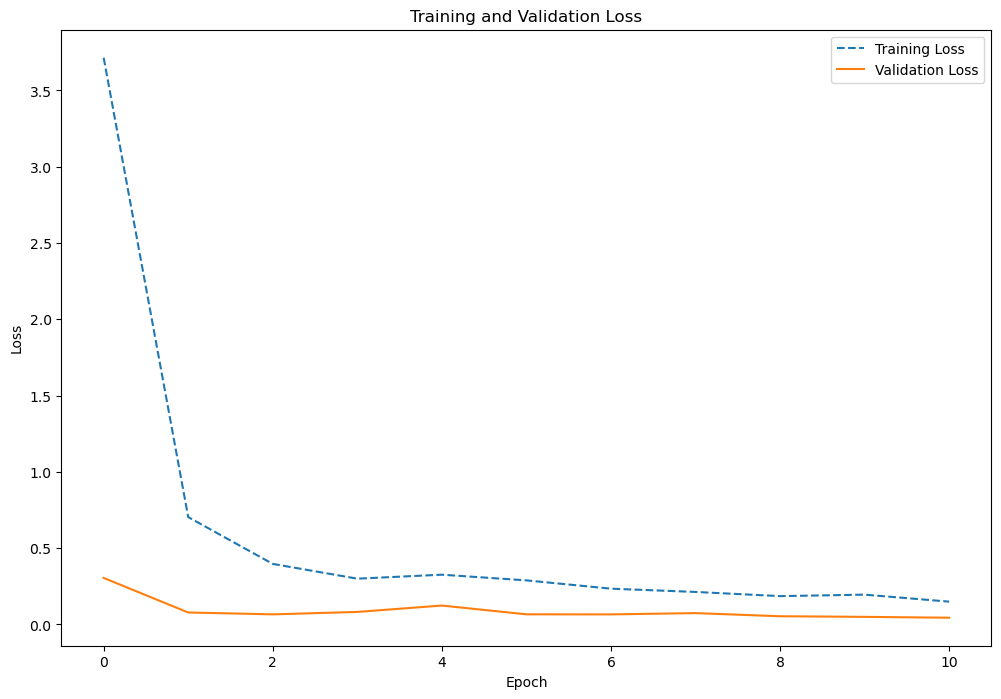

In [7]:
# Memuat histories
model_path_without_ext = model_paths[best_model_index].replace('.h5', '')
history_path = f'{model_path_without_ext}_history.pkl'
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plt.figure(figsize=(12, 8))
plt.plot(loaded_history['loss'], label='Training Loss', linestyle='--')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'RNN', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': balanced_acc_score, 
    'PRC': prc_score, 
    'Params': f'Units: {units}, Dropout: {dropout_rate}'
}])
df_2_5_base = pd.concat([df_2_5_base, new_row], ignore_index=True)
df_2_5_base

C:\Users\derik\AppData\Local\Temp\ipykernel_26496\1641053047.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2_5_base = pd.concat([df_2_5_base, new_row], ignore_index=True)


,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"


In [9]:
# Simpan prob untuk visualisasi
df_2_5_base_prob['ProbRNN'] = predictions_testprob
df_2_5_base_prob

,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,2.294341e-35,NaN,NaN,NaN,NaN
2020-01-09,2.339539e-35,NaN,NaN,NaN,NaN
2020-01-10,2.225924e-35,NaN,NaN,NaN,NaN
2020-01-13,2.272530e-35,NaN,NaN,NaN,NaN
2020-01-14,2.238902e-35,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-26,2.477086e-35,NaN,NaN,NaN,NaN
2023-10-27,2.468314e-35,NaN,NaN,NaN,NaN
2023-10-30,2.377125e-35,NaN,NaN,NaN,NaN
2023-10-31,2.462765e-35,NaN,NaN,NaN,NaN


### LSTM

In [10]:
model_paths = []

for units in [64, 128]:
    for dropout_rate in [0.1, 0.2]:
        for i in range(10):  # 10 iterasi untuk setiap konfigurasi
            model_path = f'Model/id1_lstm_units_{units}_dropout_{dropout_rate}_iteration_{i}.h5'
            model_paths.append(model_path)
best_score = 0
best_model_index = -1
results = []

for model_index in range(len(model_paths)):
    units, dropout_rate = extract_params_from_path(model_paths[model_index])
    model = make_model_LSTM(look_back=look_back, n_features=n_features, units=units, 
                           learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
    model.load_weights(model_paths[model_index])
    
    predictions_test = model.predict(X_test_lagged)
    predictions_test_prob = model.predict(X_test_lagged)
    predictions_test = (predictions_test > 0.5).astype(int)
    
    prc_score = average_precision_score(y_test_lagged, predictions_test)
    balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
    cm = confusion_matrix(y_test_lagged, predictions_test)
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    FAR = FP / (FP + TN)
    HR = TP / (TP + FN)
    
    results.append((model_index, prc_score, balanced_acc_score, FAR, HR))
    
    # Periksa apakah ini adalah model terbaik
    if prc_score > best_score:
        best_score = prc_score
        best_model_index = model_index

# Cetak hasil untuk model terbaik
print(f"Best Model Index: {best_model_index}")
units, dropout_rate = extract_params_from_path(model_paths[best_model_index])
best_model = make_model_LSTM(look_back=look_back, n_features=n_features, units=units, 
                            learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
best_model.load_weights(model_paths[best_model_index])

predictions_test = best_model.predict(X_test_lagged)
predictions_testprob = predictions_test
predictions_test = (predictions_test > 0.5).astype(int)

prc_score = average_precision_score(y_test_lagged, predictions_test)
balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
cm = confusion_matrix(y_test_lagged, predictions_test)
TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)

print(f"Test PRC Score: {prc_score}")
print(f"Test Balanced Accuracy Score: {balanced_acc_score}")
print(f"False Alarm Rate: {FAR}")
print(f"Hit Rate: {HR}")
print(f"Best Model Path: {model_paths[best_model_index]}")
print(f"Confusion Matrix: {cm}")

35/35 [==============================] - 0s 1ms/step
Best Model Index: 0
35/35 [==============================] - 0s 860us/step
Test PRC Score: 0.009830205540661306
Test Balanced Accuracy Score: 0.5
False Alarm Rate: 0.0
Hit Rate: 0.0
Best Model Path: Model/id1_lstm_units_64_dropout_0.1_iteration_0.h5
Confusion Matrix: [[1108    0]
 [  11    0]]


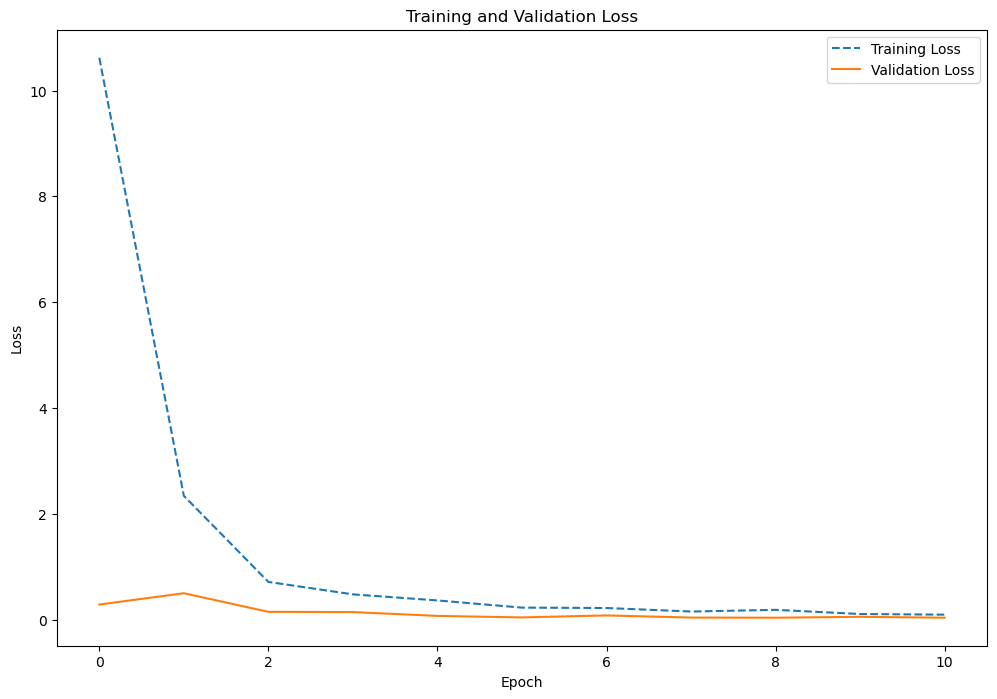

In [11]:
# Memuat histories
model_path_without_ext = model_paths[best_model_index].replace('.h5', '')
history_path = f'{model_path_without_ext}_history.pkl'
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plt.figure(figsize=(12, 8))
plt.plot(loaded_history['loss'], label='Training Loss', linestyle='--')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'LSTM', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': balanced_acc_score, 
    'PRC': prc_score, 
    'Params': f'Units: {units}, Dropout: {dropout_rate}'
}])
df_2_5_base = pd.concat([df_2_5_base, new_row], ignore_index=True)
df_2_5_base

,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"


In [13]:
# Simpan prob untuk visualisasi
df_2_5_base_prob['ProbLSTM'] = predictions_testprob
df_2_5_base_prob

,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,2.294341e-35,5.751543e-33,NaN,NaN,NaN
2020-01-09,2.339539e-35,5.010007e-33,NaN,NaN,NaN
2020-01-10,2.225924e-35,5.523319e-33,NaN,NaN,NaN
2020-01-13,2.272530e-35,5.170303e-33,NaN,NaN,NaN
2020-01-14,2.238902e-35,5.486528e-33,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-26,2.477086e-35,6.742420e-33,NaN,NaN,NaN
2023-10-27,2.468314e-35,6.944358e-33,NaN,NaN,NaN
2023-10-30,2.377125e-35,6.933505e-33,NaN,NaN,NaN
2023-10-31,2.462765e-35,7.493933e-33,NaN,NaN,NaN


### GRU

In [14]:
model_paths = []

for units in [64, 128]:
    for dropout_rate in [0.1, 0.2]:
        for i in range(10):  # 10 iterasi untuk setiap konfigurasi
            model_path = f'Model/id1_gru_units_{units}_dropout_{dropout_rate}_iteration_{i}.h5'
            model_paths.append(model_path)
best_score = 0
best_model_index = -1
results = []

for model_index in range(len(model_paths)):
    units, dropout_rate = extract_params_from_path(model_paths[model_index])
    model = make_model_GRU(look_back=look_back, n_features=n_features, units=units, 
                           learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
    model.load_weights(model_paths[model_index])
    
    predictions_test = model.predict(X_test_lagged)
    predictions_test_prob = model.predict(X_test_lagged)
    predictions_test = (predictions_test > 0.5).astype(int)
    
    prc_score = average_precision_score(y_test_lagged, predictions_test)
    balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
    cm = confusion_matrix(y_test_lagged, predictions_test)
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    FAR = FP / (FP + TN)
    HR = TP / (TP + FN)
    
    results.append((model_index, prc_score, balanced_acc_score, FAR, HR))
    
    # Periksa apakah ini adalah model terbaik
    if prc_score > best_score:
        best_score = prc_score
        best_model_index = model_index

# Cetak hasil untuk model terbaik
print(f"Best Model Index: {best_model_index}")
units, dropout_rate = extract_params_from_path(model_paths[best_model_index])
best_model = make_model_GRU(look_back=look_back, n_features=n_features, units=units, 
                            learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
best_model.load_weights(model_paths[best_model_index])

predictions_test = best_model.predict(X_test_lagged)
predictions_testprob = predictions_test
predictions_test = (predictions_test > 0.5).astype(int)

prc_score = average_precision_score(y_test_lagged, predictions_test)
balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
cm = confusion_matrix(y_test_lagged, predictions_test)
TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)

print(f"Test PRC Score: {prc_score}")
print(f"Test Balanced Accuracy Score: {balanced_acc_score}")
print(f"False Alarm Rate: {FAR}")
print(f"Hit Rate: {HR}")
print(f"Best Model Path: {model_paths[best_model_index]}")
print(f"Confusion Matrix: {cm}")

35/35 [==============================] - 0s 1ms/step
Best Model Index: 0
35/35 [==============================] - 0s 1ms/step
Test PRC Score: 0.009830205540661306
Test Balanced Accuracy Score: 0.5
False Alarm Rate: 0.0
Hit Rate: 0.0
Best Model Path: Model/id1_gru_units_64_dropout_0.1_iteration_0.h5
Confusion Matrix: [[1108    0]
 [  11    0]]


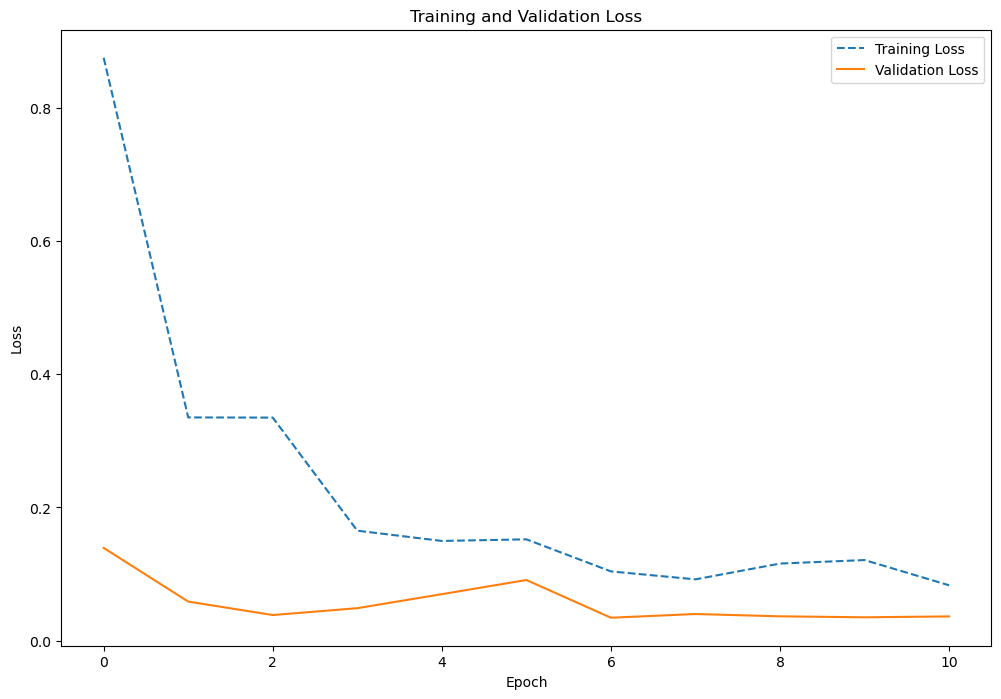

In [15]:
# Memuat histories
model_path_without_ext = model_paths[best_model_index].replace('.h5', '')
history_path = f'{model_path_without_ext}_history.pkl'
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plt.figure(figsize=(12, 8))
plt.plot(loaded_history['loss'], label='Training Loss', linestyle='--')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'GRU', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': balanced_acc_score, 
    'PRC': prc_score, 
    'Params': f'Units: {units}, Dropout: {dropout_rate}'
}])
df_2_5_base = pd.concat([df_2_5_base, new_row], ignore_index=True)
df_2_5_base

,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
2,GRU,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"


In [17]:
# Simpan prob untuk visualisasi
df_2_5_base_prob['ProbGRU'] = predictions_testprob
df_2_5_base_prob

,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,2.294341e-35,5.751543e-33,4.625629e-15,NaN,NaN
2020-01-09,2.339539e-35,5.010007e-33,4.487386e-15,NaN,NaN
2020-01-10,2.225924e-35,5.523319e-33,4.566336e-15,NaN,NaN
2020-01-13,2.272530e-35,5.170303e-33,4.578214e-15,NaN,NaN
2020-01-14,2.238902e-35,5.486528e-33,4.529712e-15,NaN,NaN
...,...,...,...,...,...
2023-10-26,2.477086e-35,6.742420e-33,4.453569e-15,NaN,NaN
2023-10-27,2.468314e-35,6.944358e-33,4.322231e-15,NaN,NaN
2023-10-30,2.377125e-35,6.933505e-33,4.316020e-15,NaN,NaN
2023-10-31,2.462765e-35,7.493933e-33,4.317008e-15,NaN,NaN


## Evaluation Smote

In [18]:
# Dataframe indonesia 2.5% nanti append tiap selesai pemodelan
# Ada kolom  - Model	Negara	TP	FP	TN	FN	HR	FR	BACC	PRC
df_2_5 = pd.DataFrame(columns=['Model', 'Negara', 'TP', 'FP', 'TN', 'FN', 'HR', 'FR', 'BACC', 'PRC', 'Params'])
df_2_5

,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params


In [19]:
# Simpan prob untuk visualisasi
df_2_5_prob = pd.DataFrame(columns=['ProbRNN','ProbLSTM', 'ProbGRU', 'ProbRF', 'ProbXGB'])
df_2_5_prob = pd.concat([df_2_5_prob, pd.DataFrame(index=y_test_lagged.index)])
df_2_5_prob

C:\Users\derik\AppData\Local\Temp\ipykernel_26496\477191898.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_2_5_prob = pd.concat([df_2_5_prob, pd.DataFrame(index=y_test_lagged.index)])


,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN
2020-01-10,NaN,NaN,NaN,NaN,NaN
2020-01-13,NaN,NaN,NaN,NaN,NaN
2020-01-14,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-26,NaN,NaN,NaN,NaN,NaN
2023-10-27,NaN,NaN,NaN,NaN,NaN
2023-10-30,NaN,NaN,NaN,NaN,NaN
2023-10-31,NaN,NaN,NaN,NaN,NaN


### RNN

In [20]:
model_paths = []

for units in [64, 128]:
    for dropout_rate in [0.1, 0.2]:
        for i in range(10):  # 10 iterasi untuk setiap konfigurasi
            model_path = f'Model/id1_rnn_smote_units_{units}_dropout_{dropout_rate}_iteration_{i}.h5'
            model_paths.append(model_path)
best_score = 0
best_model_index = -1
results = []

for model_index in range(len(model_paths)):
    units, dropout_rate = extract_params_from_path(model_paths[model_index])
    model = make_model_RNN(look_back=look_back, n_features=n_features, units=units, 
                           learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
    model.load_weights(model_paths[model_index])
    
    predictions_test = model.predict(X_test_lagged)
    predictions_test_prob = model.predict(X_test_lagged)
    predictions_test = (predictions_test > 0.5).astype(int)
    
    prc_score = average_precision_score(y_test_lagged, predictions_test)
    balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
    cm = confusion_matrix(y_test_lagged, predictions_test)
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    FAR = FP / (FP + TN)
    HR = TP / (TP + FN)
    
    results.append((model_index, prc_score, balanced_acc_score, FAR, HR))
    
    # Periksa apakah ini adalah model terbaik
    if prc_score > best_score:
        best_score = prc_score
        best_model_index = model_index

# Cetak hasil untuk model terbaik
print(f"Best Model Index: {best_model_index}")
units, dropout_rate = extract_params_from_path(model_paths[best_model_index])
best_model = make_model_RNN(look_back=look_back, n_features=n_features, units=units, 
                            learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
best_model.load_weights(model_paths[best_model_index])

predictions_test = best_model.predict(X_test_lagged)
predictions_testprob = predictions_test
predictions_test = (predictions_test > 0.5).astype(int)

prc_score = average_precision_score(y_test_lagged, predictions_test)
balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
cm = confusion_matrix(y_test_lagged, predictions_test)
TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)

print(f"Test PRC Score: {prc_score}")
print(f"Test Balanced Accuracy Score: {balanced_acc_score}")
print(f"False Alarm Rate: {FAR}")
print(f"Hit Rate: {HR}")
print(f"Best Model Path: {model_paths[best_model_index]}")
print(f"Confusion Matrix: {cm}")

35/35 [==============================] - 0s 1ms/step
Best Model Index: 1
35/35 [==============================] - 0s 600us/step
Test PRC Score: 0.1676995926325685
Test Balanced Accuracy Score: 0.723211355431572
False Alarm Rate: 0.008122743682310469
Hit Rate: 0.45454545454545453
Best Model Path: Model/id1_rnn_smote_units_64_dropout_0.1_iteration_1.h5
Confusion Matrix: [[1099    9]
 [   6    5]]


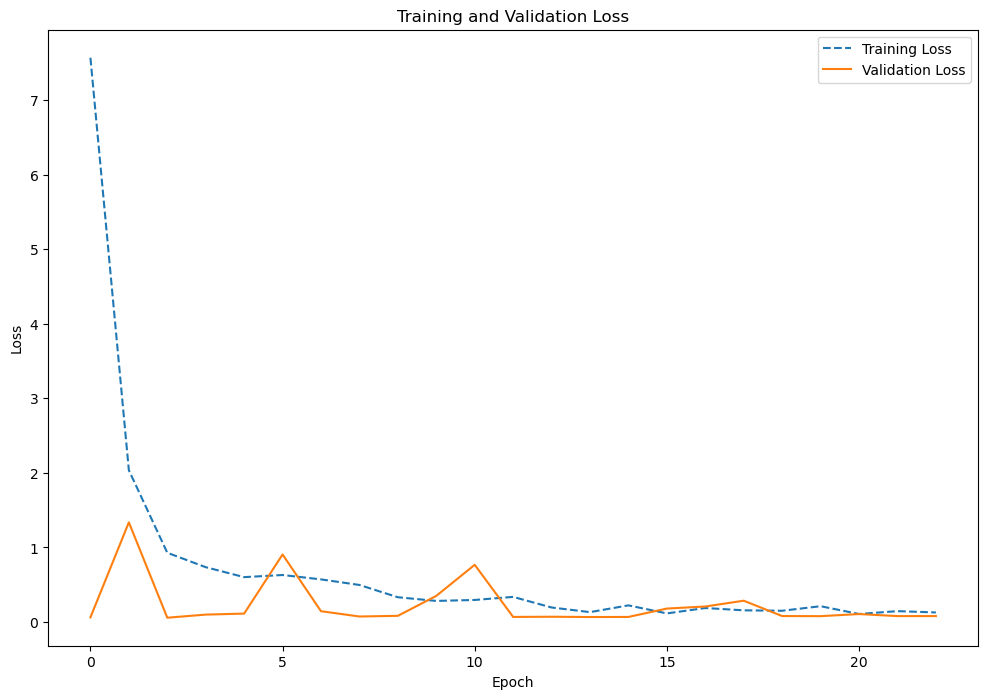

In [21]:
# Memuat histories
model_path_without_ext = model_paths[best_model_index].replace('.h5', '')
history_path = f'{model_path_without_ext}_history.pkl'
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plt.figure(figsize=(12, 8))
plt.plot(loaded_history['loss'], label='Training Loss', linestyle='--')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'RNN', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': balanced_acc_score, 
    'PRC': prc_score, 
    'Params': f'Units: {units}, Dropout: {dropout_rate}'
}])
df_2_5 = pd.concat([df_2_5, new_row], ignore_index=True)
df_2_5

C:\Users\derik\AppData\Local\Temp\ipykernel_26496\3206386942.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2_5 = pd.concat([df_2_5, new_row], ignore_index=True)


,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,5,9,1099,6,0.454545,0.008123,0.723211,0.1677,"Units: 64, Dropout: 0.1"


In [23]:
# Simpan prob untuk visualisasi
df_2_5_prob['ProbRNN'] = predictions_testprob
df_2_5_prob

,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,0.001114,NaN,NaN,NaN,NaN
2020-01-09,0.001263,NaN,NaN,NaN,NaN
2020-01-10,0.001146,NaN,NaN,NaN,NaN
2020-01-13,0.001392,NaN,NaN,NaN,NaN
2020-01-14,0.001258,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-26,0.007447,NaN,NaN,NaN,NaN
2023-10-27,0.010479,NaN,NaN,NaN,NaN
2023-10-30,0.010437,NaN,NaN,NaN,NaN
2023-10-31,0.010118,NaN,NaN,NaN,NaN


### LSTM

In [24]:
model_paths = []

for units in [64, 128]:
    for dropout_rate in [0.1, 0.2]:
        for i in range(10):  # 10 iterasi untuk setiap konfigurasi
            model_path = f'Model/id1_lstm_smote_units_{units}_dropout_{dropout_rate}_iteration_{i}.h5'
            model_paths.append(model_path)
best_score = 0
best_model_index = -1
results = []

for model_index in range(len(model_paths)):
    units, dropout_rate = extract_params_from_path(model_paths[model_index])
    model = make_model_LSTM(look_back=look_back, n_features=n_features, units=units, 
                           learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
    model.load_weights(model_paths[model_index])
    
    predictions_test = model.predict(X_test_lagged)
    predictions_test_prob = model.predict(X_test_lagged)
    predictions_test = (predictions_test > 0.5).astype(int)
    
    prc_score = average_precision_score(y_test_lagged, predictions_test)
    balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
    cm = confusion_matrix(y_test_lagged, predictions_test)
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    FAR = FP / (FP + TN)
    HR = TP / (TP + FN)
    
    results.append((model_index, prc_score, balanced_acc_score, FAR, HR))
    
    # Periksa apakah ini adalah model terbaik
    if prc_score > best_score:
        best_score = prc_score
        best_model_index = model_index

# Cetak hasil untuk model terbaik
print(f"Best Model Index: {best_model_index}")
units, dropout_rate = extract_params_from_path(model_paths[best_model_index])
best_model = make_model_LSTM(look_back=look_back, n_features=n_features, units=units, 
                            learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
best_model.load_weights(model_paths[best_model_index])

predictions_test = best_model.predict(X_test_lagged)
predictions_testprob = predictions_test
predictions_test = (predictions_test > 0.5).astype(int)

prc_score = average_precision_score(y_test_lagged, predictions_test)
balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
cm = confusion_matrix(y_test_lagged, predictions_test)
TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)

print(f"Test PRC Score: {prc_score}")
print(f"Test Balanced Accuracy Score: {balanced_acc_score}")
print(f"False Alarm Rate: {FAR}")
print(f"Hit Rate: {HR}")
print(f"Best Model Path: {model_paths[best_model_index]}")
print(f"Confusion Matrix: {cm}")

35/35 [==============================] - 0s 1ms/step
Best Model Index: 0
35/35 [==============================] - 0s 954us/step
Test PRC Score: 0.15687708181005766
Test Balanced Accuracy Score: 0.7227600918936659
False Alarm Rate: 0.009025270758122744
Hit Rate: 0.45454545454545453
Best Model Path: Model/id1_lstm_smote_units_64_dropout_0.1_iteration_0.h5
Confusion Matrix: [[1098   10]
 [   6    5]]


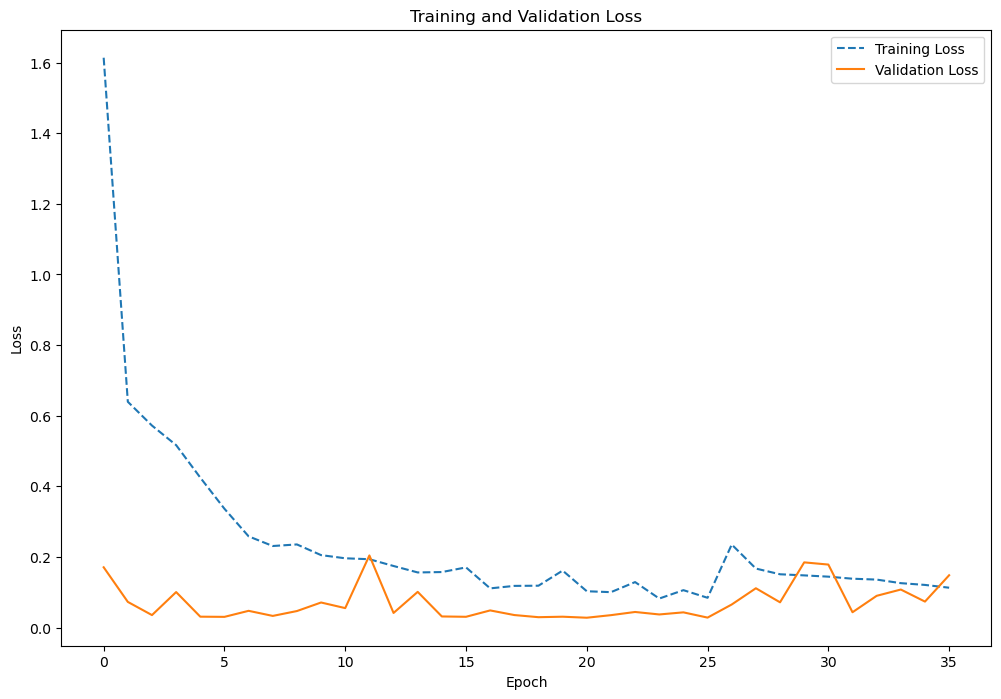

In [25]:
# Memuat histories
model_path_without_ext = model_paths[best_model_index].replace('.h5', '')
history_path = f'{model_path_without_ext}_history.pkl'
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plt.figure(figsize=(12, 8))
plt.plot(loaded_history['loss'], label='Training Loss', linestyle='--')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'LSTM', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': balanced_acc_score, 
    'PRC': prc_score, 
    'Params': f'Units: {units}, Dropout: {dropout_rate}'
}])
df_2_5 = pd.concat([df_2_5, new_row], ignore_index=True)
df_2_5

,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,5,9,1099,6,0.454545,0.008123,0.723211,0.167700,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,5,10,1098,6,0.454545,0.009025,0.722760,0.156877,"Units: 64, Dropout: 0.1"


In [27]:
# Simpan prob untuk visualisasi
df_2_5_prob['ProbLSTM'] = predictions_testprob
df_2_5_prob

,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,0.001114,0.003266,NaN,NaN,NaN
2020-01-09,0.001263,0.003248,NaN,NaN,NaN
2020-01-10,0.001146,0.002868,NaN,NaN,NaN
2020-01-13,0.001392,0.003673,NaN,NaN,NaN
2020-01-14,0.001258,0.002605,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-26,0.007447,0.006757,NaN,NaN,NaN
2023-10-27,0.010479,0.007352,NaN,NaN,NaN
2023-10-30,0.010437,0.007090,NaN,NaN,NaN
2023-10-31,0.010118,0.006820,NaN,NaN,NaN


### GRU

In [28]:
model_paths = []

for units in [64, 128]:
    for dropout_rate in [0.1, 0.2]:
        for i in range(10):  # 10 iterasi untuk setiap konfigurasi
            model_path = f'Model/id1_gru_smote_units_{units}_dropout_{dropout_rate}_iteration_{i}.h5'
            model_paths.append(model_path)
best_score = 0
best_model_index = -1
results = []

for model_index in range(len(model_paths)):
    units, dropout_rate = extract_params_from_path(model_paths[model_index])
    model = make_model_GRU(look_back=look_back, n_features=n_features, units=units, 
                           learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
    model.load_weights(model_paths[model_index])
    
    predictions_test = model.predict(X_test_lagged)
    predictions_test_prob = model.predict(X_test_lagged)
    predictions_test = (predictions_test > 0.5).astype(int)
    
    prc_score = average_precision_score(y_test_lagged, predictions_test)
    balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
    cm = confusion_matrix(y_test_lagged, predictions_test)
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    FAR = FP / (FP + TN)
    HR = TP / (TP + FN)
    
    results.append((model_index, prc_score, balanced_acc_score, FAR, HR))
    
    # Periksa apakah ini adalah model terbaik
    if prc_score > best_score:
        best_score = prc_score
        best_model_index = model_index

# Cetak hasil untuk model terbaik
print(f"Best Model Index: {best_model_index}")
units, dropout_rate = extract_params_from_path(model_paths[best_model_index])
best_model = make_model_GRU(look_back=look_back, n_features=n_features, units=units, 
                            learning_rate=0.001, num_layers=1, dropout_rate=dropout_rate)
best_model.load_weights(model_paths[best_model_index])

predictions_test = best_model.predict(X_test_lagged)
predictions_testprob = predictions_test
predictions_test = (predictions_test > 0.5).astype(int)

prc_score = average_precision_score(y_test_lagged, predictions_test)
balanced_acc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
cm = confusion_matrix(y_test_lagged, predictions_test)
TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)

print(f"Test PRC Score: {prc_score}")
print(f"Test Balanced Accuracy Score: {balanced_acc_score}")
print(f"False Alarm Rate: {FAR}")
print(f"Hit Rate: {HR}")
print(f"Best Model Path: {model_paths[best_model_index]}")
print(f"Confusion Matrix: {cm}")

35/35 [==============================] - 0s 1ms/step
Best Model Index: 12
35/35 [==============================] - 0s 1ms/step
Test PRC Score: 0.21197350054284003
Test Balanced Accuracy Score: 0.7245651460452904
False Alarm Rate: 0.005415162454873646
Hit Rate: 0.45454545454545453
Best Model Path: Model/id1_gru_smote_units_64_dropout_0.2_iteration_2.h5
Confusion Matrix: [[1102    6]
 [   6    5]]


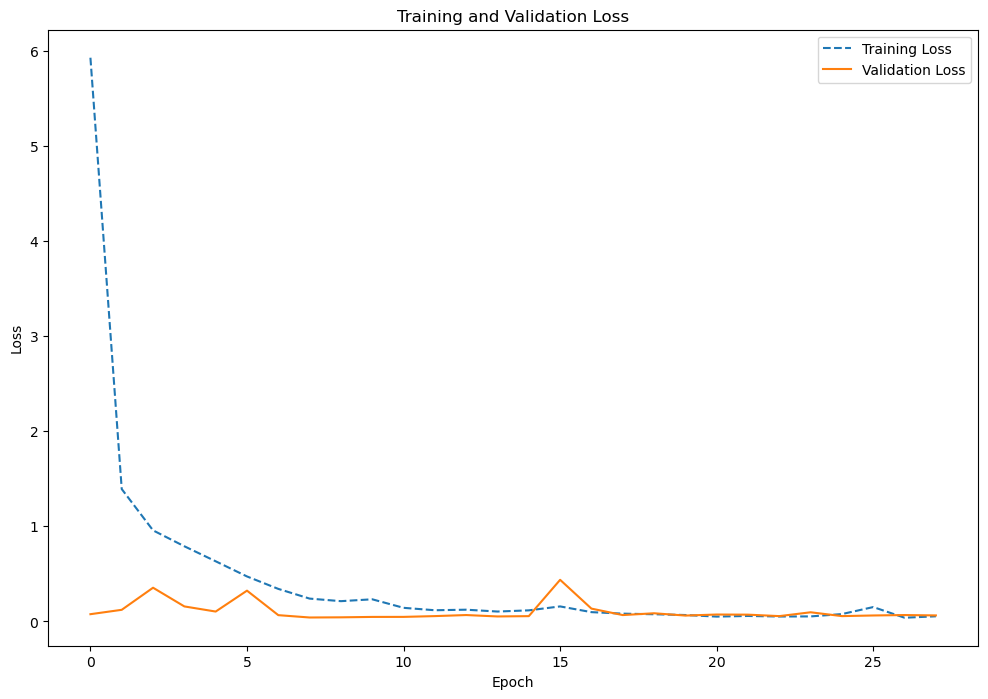

In [29]:
# Memuat histories
model_path_without_ext = model_paths[best_model_index].replace('.h5', '')
history_path = f'{model_path_without_ext}_history.pkl'
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plt.figure(figsize=(12, 8))
plt.plot(loaded_history['loss'], label='Training Loss', linestyle='--')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'GRU', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': balanced_acc_score, 
    'PRC': prc_score, 
    'Params': f'Units: {units}, Dropout: {dropout_rate}'
}])
df_2_5 = pd.concat([df_2_5, new_row], ignore_index=True)
df_2_5

,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,5,9,1099,6,0.454545,0.008123,0.723211,0.167700,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,5,10,1098,6,0.454545,0.009025,0.722760,0.156877,"Units: 64, Dropout: 0.1"
2,GRU,Indonesia,5,6,1102,6,0.454545,0.005415,0.724565,0.211974,"Units: 64, Dropout: 0.2"


In [31]:
# Simpan prob untuk visualisasi
df_2_5_prob['ProbGRU'] = predictions_testprob
df_2_5_prob

,ProbRNN,ProbLSTM,ProbGRU,ProbRF,ProbXGB
2020-01-08,0.001114,0.003266,3.445161e-08,NaN,NaN
2020-01-09,0.001263,0.003248,4.616567e-08,NaN,NaN
2020-01-10,0.001146,0.002868,3.507500e-08,NaN,NaN
2020-01-13,0.001392,0.003673,4.625593e-08,NaN,NaN
2020-01-14,0.001258,0.002605,3.830563e-08,NaN,NaN
...,...,...,...,...,...
2023-10-26,0.007447,0.006757,2.756421e-06,NaN,NaN
2023-10-27,0.010479,0.007352,1.491033e-05,NaN,NaN
2023-10-30,0.010437,0.007090,1.145849e-05,NaN,NaN
2023-10-31,0.010118,0.006820,6.128854e-06,NaN,NaN


## Evalution RF dan XGBoost

In [32]:
# Latih model pada periode train yang lebih besar
X_train_full = split_data(X, pd.Timestamp('2010-01-01'), pd.Timestamp('2019-12-31'))
y_train_full = split_data(y, pd.Timestamp('2010-01-01'), pd.Timestamp('2019-12-31'))

X_train_full_lagged = create_lagged_features(X_train_full, look_back)
y_train_full_lagged = y_train_full[look_back:]

# Uji model pada periode test
X_test = split_data(X, pd.Timestamp('2020-01-01'), pd.Timestamp('2023-11-01'))
y_test = split_data(y, pd.Timestamp('2020-01-01'), pd.Timestamp('2023-11-01'))

X_test_lagged = create_lagged_features(X_test, look_back)
y_test_lagged = y_test[look_back:]

### RF

In [33]:
# Random forest
# Memuat best_params dari file
with open('Model/id1_rf.pkl', 'rb') as f:
    best_params = pickle.load(f)
model_final = RandomForestClassifier(**best_params, random_state=1501211036)
model_final.fit(X_train_full_lagged, y_train_full_lagged)
predictions_test = model_final.predict(X_test_lagged)
prc_score = average_precision_score(y_test_lagged, predictions_test)
print(f"Test PRC  Score: {prc_score}")
bacc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
print(f"Test Balance Accuracy  Score: {bacc_score}")
cm = confusion_matrix(y_test_lagged, predictions_test)
print(cm)
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)
print("False Alarm Rate:", FAR)
print("Hit Rate:", HR)

eval_rf = {
    'Metric': ['Test PRC Score', 'Test Balance Accuracy Score', 'False Alarm Rate', 'Hit Rate'],
    'Value': [prc_score, bacc_score, FAR, HR]
}

Test PRC  Score: 0.009830205540661306
Test Balance Accuracy  Score: 0.5
[[1108    0]
 [  11    0]]
False Alarm Rate: 0.0
Hit Rate: 0.0


In [34]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'RF', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': bacc_score, 
    'PRC': prc_score, 
    'Params': f"N Estimators: {best_params['n_estimators']}, Max Depth: {best_params['max_depth']}"
}])

# Menggabungkan dengan DataFrame sebelumnya
df_2_5_base = pd.concat([df_2_5_base, new_row], ignore_index=True)
df_2_5_base


,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
2,GRU,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
3,RF,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"N Estimators: 100, Max Depth: 10"


### XGB

In [35]:
# XGB
with open('Model/id1_xgb.pkl', 'rb') as f:
    best_params = pickle.load(f)

model_final = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=1501211036)
model_final.fit(X_train_full_lagged, y_train_full_lagged)

predictions_test = model_final.predict(X_test_lagged)
prc_score = average_precision_score(y_test_lagged, predictions_test)
print(f"Test PRC  Score: {prc_score}")
bacc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
print(f"Test Balance Accuracy  Score: {bacc_score}")
cm = confusion_matrix(y_test_lagged, predictions_test)
print(cm)
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)
print("False Alarm Rate:", FAR)
print("Hit Rate:", HR)

eval_xgboost = {
    'Metric': ['Test PRC Score', 'Test Balance Accuracy Score', 'False Alarm Rate', 'Hit Rate'],
    'Value': [prc_score, bacc_score, FAR, HR]
}

Test PRC  Score: 0.009830205540661306
Test Balance Accuracy  Score: 0.5
[[1108    0]
 [  11    0]]
False Alarm Rate: 0.0
Hit Rate: 0.0


In [36]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'XGBoost', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': bacc_score, 
    'PRC': prc_score, 
    'Params': f"Learning Rate: {best_params['learning_rate']}, N Estimators: {best_params['n_estimators']}, Max Depth: {best_params['max_depth']}"
}])

# Menggabungkan dengan DataFrame sebelumnya
df_2_5_base = pd.concat([df_2_5_base, new_row], ignore_index=True)
df_2_5_base


,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
2,GRU,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Units: 64, Dropout: 0.1"
3,RF,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"N Estimators: 100, Max Depth: 10"
4,XGBoost,Indonesia,0,0,1108,11,0.0,0.0,0.5,0.00983,"Learning Rate: 0.001, N Estimators: 100, Max D..."


### RF SMOTE

In [37]:
# Latih model pada periode train yang lebih besar
X_train_full = split_data(X, pd.Timestamp('2010-01-01'), pd.Timestamp('2019-12-31'))
y_train_full = split_data(y, pd.Timestamp('2010-01-01'), pd.Timestamp('2019-12-31'))

# Handling imbalanced with smote
smote_enn = SMOTEENN(random_state=1501211036)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_full, y_train_full)

X_train_full_lagged = create_lagged_features(X_train_resampled, look_back)
y_train_full_lagged = y_train_resampled[look_back:]

# Uji model pada periode test
X_test = split_data(X, pd.Timestamp('2020-01-01'), pd.Timestamp('2023-11-01'))
y_test = split_data(y, pd.Timestamp('2020-01-01'), pd.Timestamp('2023-11-01'))

X_test_lagged = create_lagged_features(X_test, look_back)
y_test_lagged = y_test[look_back:]

In [38]:
# Random forest
# Memuat best_params dari file
with open('Model/id1_rf_smote.pkl', 'rb') as f:
    best_params = pickle.load(f)
model_final = RandomForestClassifier(**best_params, random_state=1501211036)
model_final.fit(X_train_full_lagged, y_train_full_lagged)
predictions_test = model_final.predict(X_test_lagged)
prc_score = average_precision_score(y_test_lagged, predictions_test)
print(f"Test PRC  Score: {prc_score}")
bacc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
print(f"Test Balance Accuracy  Score: {bacc_score}")
cm = confusion_matrix(y_test_lagged, predictions_test)
print(cm)
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)
print("False Alarm Rate:", FAR)
print("Hit Rate:", HR)

eval_rf = {
    'Metric': ['Test PRC Score', 'Test Balance Accuracy Score', 'False Alarm Rate', 'Hit Rate'],
    'Value': [prc_score, bacc_score, FAR, HR]
}

Test PRC  Score: 0.08077016816963199
Test Balance Accuracy  Score: 0.5895553002953725
[[1105    3]
 [   9    2]]
False Alarm Rate: 0.002707581227436823
Hit Rate: 0.18181818181818182


In [39]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'RF', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': bacc_score, 
    'PRC': prc_score, 
    'Params': f"N Estimators: {best_params['n_estimators']}, Max Depth: {best_params['max_depth']}"
}])

# Menggabungkan dengan DataFrame sebelumnya
df_2_5 = pd.concat([df_2_5, new_row], ignore_index=True)
df_2_5


,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,5,9,1099,6,0.454545,0.008123,0.723211,0.167700,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,5,10,1098,6,0.454545,0.009025,0.722760,0.156877,"Units: 64, Dropout: 0.1"
2,GRU,Indonesia,5,6,1102,6,0.454545,0.005415,0.724565,0.211974,"Units: 64, Dropout: 0.2"
3,RF,Indonesia,2,3,1105,9,0.181818,0.002708,0.589555,0.080770,"N Estimators: 200, Max Depth: 20"


### XGB SMOTE

In [40]:
# XGB
with open('Model/id1_xgb_smote.pkl', 'rb') as f:
    best_params = pickle.load(f)

model_final = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=1501211036)
model_final.fit(X_train_full_lagged, y_train_full_lagged)

predictions_test = model_final.predict(X_test_lagged)
prc_score = average_precision_score(y_test_lagged, predictions_test)
print(f"Test PRC  Score: {prc_score}")
bacc_score = balanced_accuracy_score(y_test_lagged, predictions_test)
print(f"Test Balance Accuracy  Score: {bacc_score}")
cm = confusion_matrix(y_test_lagged, predictions_test)
print(cm)
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]
FAR = FP / (FP + TN)
HR = TP / (TP + FN)
print("False Alarm Rate:", FAR)
print("Hit Rate:", HR)

eval_xgboost = {
    'Metric': ['Test PRC Score', 'Test Balance Accuracy Score', 'False Alarm Rate', 'Hit Rate'],
    'Value': [prc_score, bacc_score, FAR, HR]
}

Test PRC  Score: 0.017201013301427634
Test Balance Accuracy  Score: 0.5409419100754841
[[1098   10]
 [  10    1]]
False Alarm Rate: 0.009025270758122744
Hit Rate: 0.09090909090909091


In [41]:
# Menyimpan hasil evaluasi ke dalam DataFrame
new_row = pd.DataFrame([{
    'Model': 'XGBoost', 
    'Negara': 'Indonesia', 
    'TP': TP, 
    'FP': FP, 
    'TN': TN, 
    'FN': FN, 
    'HR': HR, 
    'FR': FAR, 
    'BACC': bacc_score, 
    'PRC': prc_score, 
    'Params': f"Learning Rate: {best_params['learning_rate']}, N Estimators: {best_params['n_estimators']}, Max Depth: {best_params['max_depth']}"
}])

# Menggabungkan dengan DataFrame sebelumnya
df_2_5 = pd.concat([df_2_5, new_row], ignore_index=True)
df_2_5


,Model,Negara,TP,FP,TN,FN,HR,FR,BACC,PRC,Params
0,RNN,Indonesia,5,9,1099,6,0.454545,0.008123,0.723211,0.167700,"Units: 64, Dropout: 0.1"
1,LSTM,Indonesia,5,10,1098,6,0.454545,0.009025,0.722760,0.156877,"Units: 64, Dropout: 0.1"
2,GRU,Indonesia,5,6,1102,6,0.454545,0.005415,0.724565,0.211974,"Units: 64, Dropout: 0.2"
3,RF,Indonesia,2,3,1105,9,0.181818,0.002708,0.589555,0.080770,"N Estimators: 200, Max Depth: 20"
4,XGBoost,Indonesia,1,10,1098,10,0.090909,0.009025,0.540942,0.017201,"Learning Rate: 0.001, N Estimators: 100, Max D..."


# Export

In [42]:
# Save to excel to folder Output
df_2_5_base.to_excel('Output/id1_base.xlsx', index=False)
df_2_5_base_prob.to_excel('Output/id1_base_prob.xlsx', index=True)
df_2_5.to_excel('Output/id1_smote.xlsx', index=False)
df_2_5_prob.to_excel('Output/id1_smote_prob.xlsx', index=True)